In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, sublevelset_heading_persistence
from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import balanced_accuracy_score, root_mean_squared_error

from traffic.core import Traffic, Flight

In [2]:
datasets = [("balanced1_2", True, True),("balanced1_2_3", False, False),("unbalanced1_2_3_4", False, False)]
name, simple, classification = datasets[1]

flights, data = flights_from_query(None, name, load_results=True)

pers_objects = get_flight_persistances(flights, name, load_results=True)
LL_data, A_data, S_data, H_data = pers_objects

weather_data = data[:, 1:]
labels = data[:, 0]
if simple: 
    labels = (labels != 1).astype(int)

C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")
C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


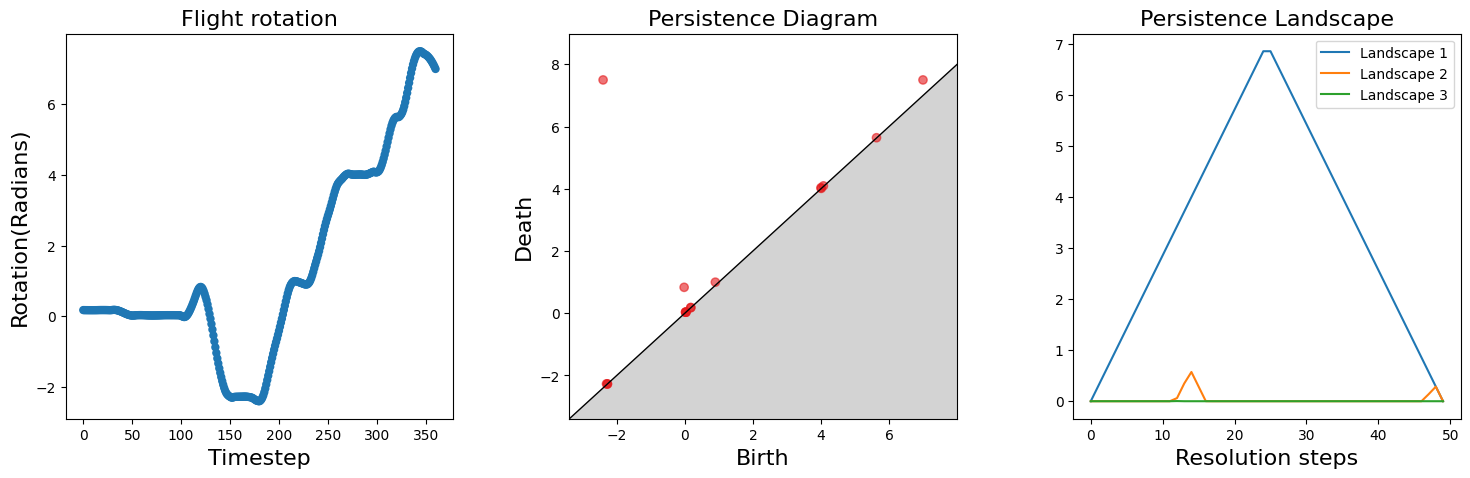

In [3]:
from gudhi.representations import Landscape

index = 3027
dataset = 3

pers = pers_objects[dataset]
pers.landscape_model = Landscape(num_landscapes=3, resolution=50, keep_endpoints=True)
pers.compute_landscapes()
fig = pers.plot_diagram(index, add_landscape=True)
#fig.savefig("H_example.svg", format="svg", dpi=1000)
pers.landscape_model = Landscape(num_landscapes=3, resolution=20, keep_endpoints=False)
pers.compute_landscapes()
None

In [4]:
from tqdm import tqdm
baseline = []

for flight in tqdm(flights, total=len(flights)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
    max_unwrapped = unwrapped.max()
    min_unwrapped = unwrapped.min()
    diff_unwrapped = max_unwrapped - min_unwrapped
    
    max_velocity = data["groundspeed"].max()
    min_velocity = data["groundspeed"].min()
    mean_velocity = data["groundspeed"].mean()
    max_heading = data["vertical_rate"].max()
    min_heading = data["vertical_rate"].min()
    mean_heading = data["vertical_rate"].mean()
    longitude_diff = data["longitude"].max() - data["longitude"].min()
    latitude_diff = data["latitude"].max() - data["latitude"].min()
    
    baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

baseline = np.array(baseline)

100%|██████████| 3037/3037 [00:01<00:00, 2394.68it/s]


In [5]:
def select_model(X, Y, seed, jobs=6):
    models = Models(seed).classifiers if classification else Models(seed).regressors
    trained_models = []
    errors = []
    
    normalizer = preprocessing.StandardScaler()
    X = normalizer.fit_transform(X)

    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

    for i in models.keys():
        model = GridSearchCV(
            models[i][0], 
            models[i][1],
            scoring="balanced_accuracy" if classification else "neg_root_mean_squared_error",
            cv=kfold,
            n_jobs=jobs
        )
        model.fit(X, Y)
        
        trained_models.append(model.best_estimator_)
        errors.append(model.best_score_)

    return trained_models, errors

In [6]:
seed = 42

B = [baseline]
LL = [LL_data.stats]
A = [A_data.stats]
S = [S_data.stats]
H = [H_data.stats]

In [7]:
errors = []

datasets = {
    "B": B,
    "LL": LL,
    "A": A,
    "S": S,
    "H": H,
    "LL+A": LL+A,
    "S+H": S+H,
    "LL+S+H": LL+S+H,
    "LL+A+S+H": LL+A+S+H,
    "B+LL+S+H": B+LL+S+H,
    "B+LL+A+S+H": B+LL+A+S+H
}

for name, dataset in datasets.items():
    X = np.concatenate(dataset, axis=1)
    mask = np.logical_and(~np.any(np.isnan(X), axis=1), ~np.isnan(labels))
    X = X[mask]
    Y = labels[mask]
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

    normalizer = preprocessing.StandardScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)

    models, errors = select_model(x_train, y_train, seed=seed, jobs=12)
    
    best_model = models[np.argmax(errors)]
    
    test_pred = best_model.predict(x_test)
    final_error = root_mean_squared_error(y_test, test_pred)
    
    best_model_name = str(best_model).split("(")[0]
    print(f"{best_model_name}: {final_error}")

RandomForestRegressor: 0.34707276019549277
RandomForestRegressor: 0.4465351788373012
RandomForestRegressor: 0.3871306243456693
RandomForestRegressor: 0.407565865424963
RandomForestRegressor: 0.3697774198657432
RandomForestRegressor: 0.3749929526133963


KeyboardInterrupt: 

In [8]:
from sklearn.metrics import confusion_matrix, root_mean_squared_error

confusion_matrix(y_val, np.round(prediction))

NameError: name 'y_val' is not defined

In [12]:
identified = np.where(np.logical_and(y_val == 2, np.round(prediction) > 5))

index = indices_val[identified[0]][0]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

#### B:          0.992
#### S:          0.948
#### H:          0.982
#### A:          0.949
#### LL:         0.943
#### S+H+A:      0.980
#### LL+S+H+A:   0.984
#### B+LL+S+H+A: 0.994
#### B+H:        0.995
#### B+LL+H      0.995
#### B+LL+S+H    0.996

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


In [42]:
false_negatives = np.where(np.logical_and(y_val == 2, prediction == 1))[0]
false_positives = np.where(np.logical_and(y_val == 1, prediction == 2))[0]
positives = np.where(y_val == 1)[0]


index = 0
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
error = np.abs(y_val - prediction)  # Absolute error

# Scatter plot with color based on error
plt.scatter(y_val, prediction, c=error, cmap='plasma')